We solve the Neoclassical Growth Model with Capital(k) and Productivity (y):
\begin{align}
  \rho V(k,y) &= \max_{c} [ u(c) +  \partial_k V (F(k,y)-\delta k - c) + \mu(y)\partial_y V(k,y) + \frac{\sigma^2(y)}{2} \partial_{yy}  V(k,y) ] \\
  &u(c) = \frac{c^{1-\sigma}}{1-\sigma}, ~~~
  F(k)=y k^\alpha, ~~~
  dy_t=\mu d_t+\sigma dz_t
\end{align}


In [1]:
import numpy as np

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# x = np.linspace(1, 10, num=10)
# inputs = tf.constant(x)
# def function(x):
#   return x**2

# with tf.GradientTape() as t: #(persistent=True)
#     t.watch(inputs)
#     y = function(inputs)

# dy_dx = t.gradient(y, inputs).numpy()
# print(dy_dx)

In [3]:
# x = np.linspace(1, 10, num=10)
# inputs = tf.Variable(x) 
# with tf.GradientTape() as t1:
#     with tf.GradientTape() as t2:
#         y = function(inputs)
# #      y = inputs * inputs * inputs
#     dy_dx = t2.gradient(y, inputs)
# d2y_dx2 = t1.gradient(dy_dx, inputs).numpy()
# print(d2y_dx2)

In [4]:
sigma = 2 # 1 changes to log utility
alpha = 0.3
delta = 0.05
rho = 0.05

In [5]:
# ORNSTEIN-UHLENBECK PROCESS dlog(z) = -theta*log(z)dt + sig2*dW
# STATIONARY DISTRIBUTION IS log(z) ~ N(0,Var) WHERE Var = sig2/(2*theta)
Var = 0.07
zmean = np.exp(Var/2) #MEAN OF LOG-NORMAL DISTRIBUTION N(0,Var)
Corr = 0.9
theta = -np.log(Corr) # this is mu
sig2 = 2*theta*Var # this is sigma

ymin = zmean*0.8
ymax = zmean*1.2

print("ymin:",ymin)
print("ymax:",ymax)

#DRIFT (FROM ITO'S LEMMA)
def mu(y):
    return (-theta*np.log(y) + sig2/2)*y 

# VARIANCE (FROM ITO'S LEMMA)
def sigma2(y):
    return sig2*y**2

ymin: 0.8284957670396986
ymax: 1.242743650559548


In [6]:
kss = (alpha/(rho+delta))**(1/(1-alpha))
kmin = 0.001*kss
kmax = 2*kss
print("kmin:",kmin)
print("kmax:",kmax)

kmin: 0.0048039866566730914
kmax: 9.607973313346182


In [7]:
train_num = 10000
# x_train = np.random.uniform(kmin,kmax,(train_num,1))
k_train = np.linspace(kmin, kmax, num=train_num).reshape(train_num,1)
k_train.shape

y_train = np.linspace(ymin, ymax, num=train_num).reshape(train_num,1)
y_train.shape

(10000, 1)

In [8]:
def build_model():
  model = keras.Sequential([
    layers.Dense(36, activation='tanh', input_shape=[2]), #use_bias=True
    layers.Dense(36, activation='tanh'), #use_bias=False     
    layers.Dense(36, activation='tanh'), #use_bias=False
#     layers.Dense(16, activation='relu'), #use_bias=False     
    layers.Dense(1) #,kernel_constraint=keras.constraints.NonNeg()
  ])

  optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
#   optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                )
  return model

In [9]:
model = build_model()

In [10]:
model.summary()
# model.get_weights() 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 36)                108       
_________________________________________________________________
dense_1 (Dense)              (None, 36)                1332      
_________________________________________________________________
dense_2 (Dense)              (None, 36)                1332      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 37        
Total params: 2,809
Trainable params: 2,809
Non-trainable params: 0
_________________________________________________________________


In [11]:
z_train = - 11/81*(k_train-9)**2 - 13 + 10*(y_train-1)

k_norm = (k_train-kmin)/(kmax-kmin)
y_norm = (y_train-ymin)/(ymax-ymin)

x_train = np.concatenate((k_norm, y_train), axis=1)
model.fit( x_train, z_train, epochs=50,validation_split = 0.2, verbose=1 ) # ,batch_size=5000

Train on 8000 samples, validate on 2000 samples
Epoch 1/50
8000/8000 [==============================] - 1s 76us/sample - loss: 85.0090 - val_loss: 15.2113
Epoch 2/50
8000/8000 [==============================] - 0s 49us/sample - loss: 18.3723 - val_loss: 36.7833
Epoch 3/50
8000/8000 [==============================] - 1s 100us/sample - loss: 16.9328 - val_loss: 39.4399
Epoch 4/50
8000/8000 [==============================] - 1s 63us/sample - loss: 16.9001 - val_loss: 38.7566
Epoch 5/50
8000/8000 [==============================] - 0s 49us/sample - loss: 16.8984 - val_loss: 38.8340
Epoch 6/50
8000/8000 [==============================] - 0s 55us/sample - loss: 16.8890 - val_loss: 40.1153
Epoch 7/50
8000/8000 [==============================] - 0s 56us/sample - loss: 16.8794 - val_loss: 39.7559
Epoch 8/50
8000/8000 [==============================] - 0s 53us/sample - loss: 16.8788 - val_loss: 39.9349
Epoch 9/50
8000/8000 [==============================] - 0s 49us/sample - loss: 16.8662 - val_lo

2.1704572075132136


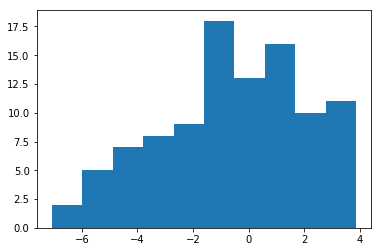

In [12]:
# k_test = np.linspace(kmin,kmax,num=99).reshape(99,1)
# y_test = np.linspace(ymin,ymax,num=99).reshape(99,1)

k_test = np.random.uniform(kmin,kmax,(99,1))
y_test = np.random.uniform(ymin,ymax,(99,1))

k_tnorm = (k_test-kmin)/(kmax-kmin)
y_tnorm = (y_test-ymin)/(ymax-ymin)


x_test = np.concatenate((k_tnorm, y_test), axis=1)

# z_test = k_test**2 + y_test**2
z_test = - 11/81*(k_test-9)**2 - 13 + 10*(y_test-1)


error = z_test.reshape(99,1) - model.predict([x_test])

print(np.mean(abs(error)))

plt.hist(error, bins=10) 
plt.show()

Text(0.5,0,'Value')

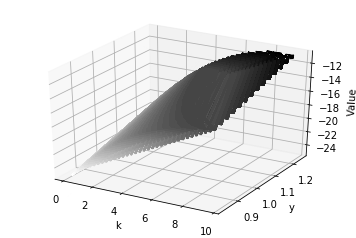

In [13]:
from mpl_toolkits import mplot3d

def f(x, y):
#     return np.sin(np.sqrt(x ** 2 + y ** 2))
    return - 11/81*(x-9)**2 - 13 + 10*(y-1)

X, Y = np.meshgrid(k_test, y_test)
Z = f(X, Y)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, Z, 50, cmap='binary')
ax.set_xlabel('k')
ax.set_ylabel('y')
ax.set_zlabel('Value')

In [14]:
inputs = tf.Variable(x_train) 

with tf.GradientTape() as t1:
    with tf.GradientTape() as t2:
        output = inputs*inputs
#         output = model(inputs)
#      y = inputs * inputs * inputs
    dV1 = t2.gradient(output, inputs)
dV2 = t1.gradient(dV1, inputs).numpy()

[dV_dk,dV_dy] = np.hsplit(dV1, 2)
[d2V_dk2,d2V_dy2] = np.hsplit(dV2, 2)

In [15]:
counter = 1
dt = 1*1e-2       # this is the learning rate for TD Reinforcement Learning
criteria = 1e-2
converge_error = 10
error_history = []

In [16]:
# for counter in range(counter):
while converge_error > criteria and counter<50:
        value = model.predict([x_train])
#         print(type(value))
          
        with tf.GradientTape() as t1:
            with tf.GradientTape() as t2:
                 # output = inputs*inputs
                output = model(inputs)
            dV1 = t2.gradient(output, inputs)
        dV2 = t1.gradient(dV1, inputs).numpy()

        [dV_dk,dV_dy] = np.hsplit(dV1, 2)
        [d2V_dk2,d2V_dy2] = np.hsplit(dV2, 2)
        
#         print(dV1)

        for i in range(train_num):
            dV_dk[i] = np.maximum(dV_dk[i], 1e-4)
            
        # with sigma=2 CRRA utility function
        HJB = (1/np.sqrt(dV_dk))**(1-sigma)/(1-sigma)\
                +dV_dk*(y_train*(k_train)**alpha-delta*k_train-1/np.sqrt(dV_dk))\
                +mu(y_train)*dV_dy +1/2*sigma2(y_train)*d2V_dy2 -rho*value
#         print(HJB)
        value += dt*HJB
        model.fit( x_train, value,  epochs=10, validation_split = 0.2, verbose=0 )
        
        counter += 1
        converge_error = np.mean(abs(HJB))
        error_history.append(np.mean(abs(HJB)))
        print(counter,  max(abs(HJB)), np.mean(abs(HJB)))

2 [17.78938406] 14.388719745906986
3 [17.71093905] 14.2678878367832
4 [17.67199207] 14.286333818247556
5 [17.60731153] 14.199453658733546
6 [17.62216229] 14.156833868561144
7 [17.57433168] 14.108065584207178
8 [17.54359905] 14.048803574075654
9 [17.49288864] 13.995536286904375
10 [17.4443342] 13.937739404474536
11 [17.40847485] 13.845912592141197
12 [17.42704978] 13.791199405254392
13 [17.37822729] 13.742229021696584
14 [17.5338838] 13.83536847766264
15 [17.7164337] 13.969773168270077
16 [17.80389665] 14.103932508423826
17 [20.2135888] 14.283023573096548
18 [22.58474312] 14.47028242983986
19 [26.11511659] 14.86362136327828
20 [29.07529124] 15.21572898828435
21 [31.82724883] 15.60749483243361
22 [33.35887565] 15.883468589937145
23 [34.33741228] 16.179166994507803
24 [34.62298769] 16.36516801184666
25 [34.58956401] 16.589564618356384
26 [34.17386492] 16.692212012105124
27 [34.51302782] 16.927049958861595
28 [34.04141296] 17.135754970164378
29 [34.00421114] 17.3823128040192
30 [33.7294340

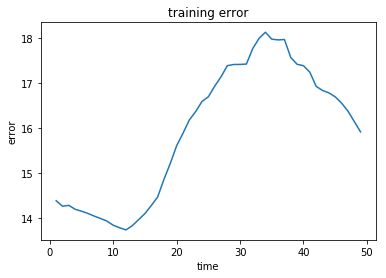

In [17]:
x = np.linspace(1, len(error_history), num=len(error_history))
y = np.array(error_history)

plt.plot(x,y)

plt.xlabel('time')
plt.ylabel('error')
plt.title('training error')
plt.show()

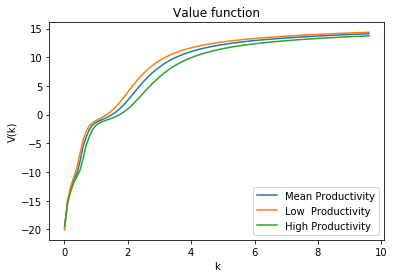

In [18]:
k_vec  = np.linspace(kmin, kmax, num=100).reshape(100,1)
y_mean = np.ones(100).reshape(100,1)
y_low  = ymin*np.ones(100).reshape(100,1)
y_high = ymax*np.ones(100).reshape(100,1)

z_mean = model.predict([np.concatenate((k_vec, y_mean), axis=1)])
z_low  = model.predict([np.concatenate((k_vec, y_low ), axis=1)])
z_high = model.predict([np.concatenate((k_vec, y_high), axis=1)])


# plt.plot(k_vec,z_mean,k_vec,z_low,k_vec,z_high)

plt.plot(k_vec,z_mean,label='Mean Productivity')
plt.plot(k_vec,z_low, label='Low  Productivity')
plt.plot(k_vec,z_high,label='High Productivity')

plt.legend()
plt.xlabel('k')
plt.ylabel('V(k)')
plt.title('Value function')
plt.show()

In [19]:
# from tensorflow.keras.models import load_model

# model.save('NCG_TD.h5')  # creates a HDF5 file 'my_model.h5'
# # del model  # deletes the existing model

# # returns a compiled model
# # identical to the previous one
# # model = load_model('my_model.h5')